
## Project Overview

This project addresses a **supervised regression problem** using deep learning techniques. The objective is to predict the spatial coordinates **(x, y)** of a single pixel with an intensity value of **255** in a **50×50 grayscale image**, where all remaining pixels have a value of **0**.

Each input image contains **exactly one bright pixel** placed at a random location. The task is to learn a mapping from the image pixel space to its corresponding coordinate representation. Since the output consists of **continuous numerical values** representing pixel positions, the problem is formulated as a **regression task** rather than a classification problem.

A **synthetic dataset** is generated programmatically to ensure full control over data distribution, labeling accuracy, and reproducibility. This approach enables precise supervision and allows the modeling pipeline to be extended to handle noise, preprocessing, and robustness considerations, closely resembling real-world image-based regression workflows.

The primary focus of this assignment is on **approach, clarity of reasoning, and implementation quality**, rather than achieving maximum predictive accuracy.



In [169]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# -------------------------
# Dataset configuration
# -------------------------
IMAGE_SIZE = 50
PIXEL_VALUE = 255
BACKGROUND_VALUE = 0

TOTAL_SAMPLES = 50000
#Noisy data used in the dataset to handle noisy images as test cases
CLEAN_RATIO = 0.6          #The 60% of the clean data are used and 40% of noisy data are used 
NOISE_RATIO = 0.02         # Amount of pixels affected due to noise

NUM_CLEAN = int(TOTAL_SAMPLES * CLEAN_RATIO)
NUM_NOISY = TOTAL_SAMPLES - NUM_CLEAN

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [170]:

#Generate images
def generate_clean_image(image_size=50):
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    y = np.random.randint(0, image_size)
    x = np.random.randint(0, image_size)

    image[y, x] = PIXEL_VALUE
    return image, (x, y)

#Add noise to clean images
def add_random_noise(image, noise_ratio=0.02):
    noisy_image = image.copy()
    num_noise_pixels = int(noise_ratio * image.size)

    noise_indices = np.random.choice(
        image.size, num_noise_pixels, replace=False
    )

    for idx in noise_indices:
        row = idx // image.shape[1]
        col = idx % image.shape[1]
        noisy_image[row, col] = np.random.randint(0, 256)

    return noisy_image

#To generate the noisy images using the add_random_noise function
def generate_noisy_image(image_size=50, noise_ratio=0.02):
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    # Place the true signal pixel
    y_signal = np.random.randint(0, image_size)
    x_signal = np.random.randint(0, image_size)
    image[y_signal, x_signal] = 255

    # Add noise everywhere EXCEPT the signal pixel
    num_noise_pixels = int(noise_ratio * image.size)
    possible_indices = [
        i for i in range(image.size)
        if (i // image_size, i % image_size) != (y_signal, x_signal)
    ]

    noise_indices = np.random.choice(
        possible_indices, num_noise_pixels, replace=False
    )

    for idx in noise_indices:
        r = idx // image_size
        c = idx % image_size
        image[r, c] = np.random.randint(0, 256)

    return image, (x_signal, y_signal)


In [171]:

def build_raw_dataset():
    images = []
    labels = []
    metadata = []

    # Generate clean samples
    for _ in range(NUM_CLEAN):
        img, coord = generate_clean_image(IMAGE_SIZE)
        images.append(img)
        labels.append(coord)
        metadata.append("clean")

    # Generate noisy samples
    for _ in range(NUM_NOISY):
        img, coord = generate_noisy_image(IMAGE_SIZE, NOISE_RATIO)
        images.append(img)
        labels.append(coord)
        metadata.append("noisy")

    images = np.array(images, dtype=np.uint8)
    labels = np.array(labels, dtype=np.int32)
    metadata = np.array(metadata)

    return images, labels, metadata


In [172]:
X_raw, y_raw, sample_type = build_raw_dataset()

print("Dataset shape:", X_raw.shape)
print("Labels shape:", y_raw.shape)
print("Sample label:", y_raw[0])


Dataset shape: (50000, 50, 50)
Labels shape: (50000, 2)
Sample label: [28 38]


In [173]:
#Saving dataset in zip format
import zipfile
import os

# -------------------------
# Build dataset
# -------------------------

X_raw, y_raw, sample_type = build_raw_dataset()

print("Dataset built:")
print("Images shape:", X_raw.shape)
print("Labels shape:", y_raw.shape)
print("Metadata shape:", sample_type.shape)


# -------------------------
# Save dataset to NPZ
# -------------------------

DATASET_NAME = "pixel_coordinate_dataset"
NPZ_FILE = f"{DATASET_NAME}.npz"
ZIP_FILE = f"{DATASET_NAME}.zip"

np.savez_compressed(
    NPZ_FILE,
    images=X_raw,
    labels=y_raw,
    sample_type=sample_type
)

print(f"Saved NPZ file: {NPZ_FILE}")


# -------------------------
# Zip the dataset
# -------------------------

with zipfile.ZipFile(ZIP_FILE, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(NPZ_FILE)

# Optional: remove standalone NPZ after zipping
os.remove(NPZ_FILE)

print(f"Dataset zipped successfully: {ZIP_FILE}")


Dataset built:
Images shape: (50000, 50, 50)
Labels shape: (50000, 2)
Metadata shape: (50000,)
Saved NPZ file: pixel_coordinate_dataset.npz
Dataset zipped successfully: pixel_coordinate_dataset.zip


In [174]:
assert y_raw.shape == (50000, 2), "Label shape is incorrect"


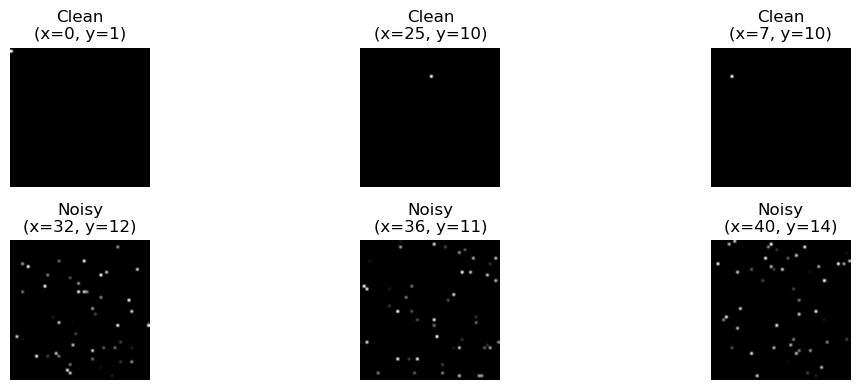

In [175]:
# A small subset of clean and noisy samples is visualized
# to validate dataset composition before cleaning and preprocessing

num_samples_each = 3

clean_indices = np.where(sample_type == "clean")[0]
noisy_indices = np.where(sample_type == "noisy")[0]

selected_clean = np.random.choice(clean_indices, num_samples_each, replace=False)
selected_noisy = np.random.choice(noisy_indices, num_samples_each, replace=False)

plt.figure(figsize=(12, 4))

# Plot clean samples (top row)
for i, idx in enumerate(selected_clean):
    plt.subplot(2, num_samples_each, i + 1)
    plt.imshow(X_raw[idx], cmap="gray")
    plt.title(f"Clean\n(x={y_raw[idx][0]}, y={y_raw[idx][1]})")
    plt.axis("off")

# Plot noisy samples (bottom row)
for i, idx in enumerate(selected_noisy):
    plt.subplot(2, num_samples_each, num_samples_each + i + 1)
    plt.imshow(X_raw[idx], cmap="gray")
    plt.title(f"Noisy\n(x={y_raw[idx][0]}, y={y_raw[idx][1]})")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [176]:
#Data Cleaning

In [177]:
# Dataset sanity checks

unique_pixel_values = np.unique(X_raw)

print(
    "Raw dataset pixel value range:",
    unique_pixel_values.min(),
    "to",
    unique_pixel_values.max()
)

clean_count = np.sum(sample_type == "clean")
noisy_count = np.sum(sample_type == "noisy")

print(f"Clean samples: {clean_count}")
print(f"Noisy samples: {noisy_count}")

# Sanity check: dataset size consistency
assert clean_count + noisy_count == X_raw.shape[0], (
    "Mismatch between dataset size and sample type counts"
)


Raw dataset pixel value range: 0 to 255
Clean samples: 30000
Noisy samples: 20000


In [178]:
# Signal-preserving and robust cleaning
def clean_image_preserve_signal(image):
    """
    Preserve the strongest signal pixel and remove all others.
    Robust to noise containing high-intensity values.
    """
    cleaned_image = np.zeros_like(image)

    # Find the strongest pixel (guaranteed to be the signal)
    y, x = np.unravel_index(np.argmax(image), image.shape)
    cleaned_image[y, x] = 255

    return cleaned_image


In [179]:

# Rebuild cleaned dataset explicitly

X_cleaned = np.zeros_like(X_raw)

for i in range(len(X_raw)):
    X_cleaned[i] = clean_image_preserve_signal(X_raw[i])

print("Unique values in cleaned dataset:", np.unique(X_cleaned))


Unique values in cleaned dataset: [  0 255]


In [180]:

#Cleaning validation

active_pixels = np.sum(X_cleaned > 0, axis=(1, 2))
unique_counts = np.unique(active_pixels)

print("Unique active pixel counts after cleaning:", unique_counts)

assert np.array_equal(unique_counts, [1]), (
    "ERROR: Each cleaned image must contain exactly one active pixel"
)

Unique active pixel counts after cleaning: [1]


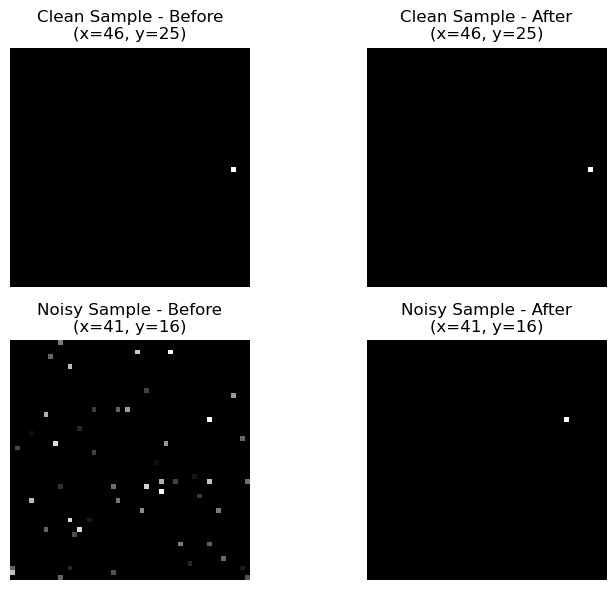

In [181]:
# Visualize before vs after cleaning for one clean and one noisy sample

# Select one clean and one noisy index
clean_idx = np.random.choice(np.where(sample_type == "clean")[0])
noisy_idx = np.random.choice(np.where(sample_type == "noisy")[0])

indices = [clean_idx, noisy_idx]
titles = ["Clean Sample", "Noisy Sample"]

plt.figure(figsize=(8, 6))

for i, idx in enumerate(indices):
    x_coord, y_coord = y_raw[idx]

    # Before cleaning
    plt.subplot(2, 2, i * 2 + 1)
    plt.imshow(X_raw[idx], cmap="gray")
    plt.title(f"{titles[i]} - Before\n(x={x_coord}, y={y_coord})")
    plt.axis("off")

    # After cleaning
    plt.subplot(2, 2, i * 2 + 2)
    plt.imshow(X_cleaned[idx], cmap="gray")
    plt.title(f"{titles[i]} - After\n(x={x_coord}, y={y_coord})")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [182]:
#Dataset Preprocessing

In [183]:

# Sanity check before normalization

print("Before normalization:")
print("Min pixel value:", X_cleaned.min())
print("Max pixel value:", X_cleaned.max())
print("Data type:", X_cleaned.dtype)

assert X_cleaned.max() == 255, "Unexpected max pixel value"
assert X_cleaned.min() == 0, "Unexpected min pixel value"


Before normalization:
Min pixel value: 0
Max pixel value: 255
Data type: uint8


In [184]:
# -------------------------
# Image normalization
# -------------------------

X_normalized = X_cleaned.astype("float32") / 255.0

# Add channel dimension for CNN
X_normalized = X_normalized[..., np.newaxis]

print("Normalized image shape:", X_normalized.shape)

assert X_normalized.shape[-1] == 1, "Missing channel dimension"


Normalized image shape: (50000, 50, 50, 1)


In [185]:
# Label preprocessing (heatmap generation)

IMAGE_SIZE = 50  # image height/width


def generate_heatmap(x, y, size=50):
    """
    Generate a 2D heatmap with a single active pixel.
    """
    heatmap = np.zeros((size, size), dtype=np.float32)
    heatmap[y, x] = 1.0
    return heatmap


# Convert (x, y) labels into heatmaps
y_heatmaps = np.array(
    [generate_heatmap(x, y, IMAGE_SIZE) for x, y in y_raw],
    dtype=np.float32
)

# Add channel dimension: (N, 50, 50, 1)
y_heatmaps = y_heatmaps[..., np.newaxis]

print("Heatmap labels shape:", y_heatmaps.shape)
print("Unique heatmap values:", np.unique(y_heatmaps))

# Safety checks
assert y_heatmaps.shape[1:] == (IMAGE_SIZE, IMAGE_SIZE, 1), \
    "Heatmaps must have shape (50, 50, 1)"

assert np.array_equal(np.unique(y_heatmaps), [0.0, 1.0]), \
    "Heatmaps must contain only 0 and 1"


Heatmap labels shape: (50000, 50, 50, 1)
Unique heatmap values: [0. 1.]


In [186]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val, coords_train, coords_val = train_test_split(
    X_normalized,
    y_heatmaps,
    y_raw,          # <-- keep original (x, y)
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Validation GT coords shape:", coords_val.shape)


Training set shape: (40000, 50, 50, 1) (40000, 50, 50, 1)
Validation set shape: (10000, 50, 50, 1) (10000, 50, 50, 1)
Validation GT coords shape: (10000, 2)


In [187]:
#Coordinate Scaling(Regression Targets)

In [189]:
# Reshape for CNN input
print("Final input shape for model:", X_normalized.shape)

assert X_normalized.ndim == 4, "Input must be 4D (N, H, W, C)"
assert X_normalized.shape[-1] == 1, "Channel dimension must be 1"


Final input shape for model: (50000, 50, 50, 1)


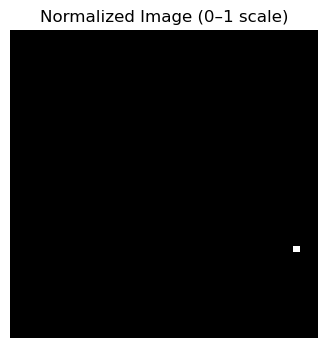

In [192]:
# Visual check after normalization

idx = np.random.randint(0, len(X_normalized))

plt.figure(figsize=(4, 4))
plt.imshow(X_normalized[idx].squeeze(), cmap="gray")
plt.title("Normalized Image (0–1 scale)")
plt.axis("off")
plt.show()


In [193]:
#Exploratory Data Analysis(EDA)

In [194]:
# Raw dataset sanity check

unique_pixel_values = np.unique(X_raw)

print(
    "Raw dataset pixel value range:",
    unique_pixel_values.min(),
    "to",
    unique_pixel_values.max()
)

clean_count = np.sum(sample_type == "clean")
noisy_count = np.sum(sample_type == "noisy")

print(f"Clean samples: {clean_count}")
print(f"Noisy samples: {noisy_count}")

# Safety check
assert clean_count + noisy_count == X_raw.shape[0], (
    "Mismatch between dataset size and sample type counts"
)


Raw dataset pixel value range: 0 to 255
Clean samples: 30000
Noisy samples: 20000


In [195]:
#  Pixel integrity after cleaning

unique_values, counts = np.unique(X_cleaned, return_counts=True)

print("Pixel intensity distribution after cleaning:")
for value, count in zip(unique_values, counts):
    print(f"Pixel value {value}: {count} occurrences")

# Hard invariant check
assert set(unique_values).issubset({0, 255}), (
    "ERROR: Cleaned dataset contains unexpected pixel values"
)


Pixel intensity distribution after cleaning:
Pixel value 0: 124950000 occurrences
Pixel value 255: 50000 occurrences


In [196]:
# Verification after forced rebuild
print(np.unique(X_cleaned))


[  0 255]


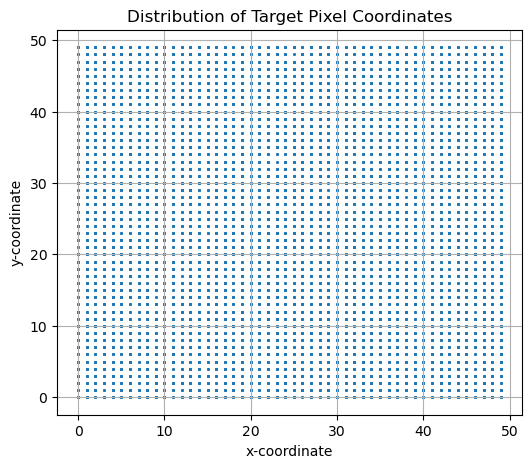

In [197]:
# Coordinate distribution

x_coords = y_raw[:, 0]
y_coords = y_raw[:, 1]

plt.figure(figsize=(6, 5))
plt.scatter(x_coords, y_coords, s=1, alpha=0.3)
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("Distribution of Target Pixel Coordinates")
plt.grid(True)
plt.show()


In [198]:
# Active pixel count per image

active_pixels = np.sum(X_cleaned > 0, axis=(1, 2))
unique_counts = np.unique(active_pixels)

print("Unique active pixel counts after cleaning:", unique_counts)

assert np.array_equal(unique_counts, [1]), (
    "ERROR: Each cleaned image must contain exactly one active pixel"
)


Unique active pixel counts after cleaning: [1]


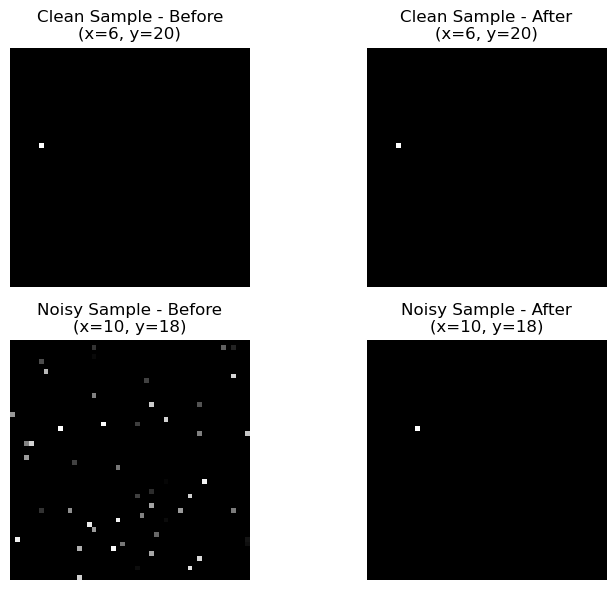

In [199]:
# Visual before vs after cleaning

clean_idx = np.random.choice(np.where(sample_type == "clean")[0])
noisy_idx = np.random.choice(np.where(sample_type == "noisy")[0])

indices = [clean_idx, noisy_idx]
titles = ["Clean Sample", "Noisy Sample"]

plt.figure(figsize=(8, 6))

for i, idx in enumerate(indices):
    x_coord, y_coord = y_raw[idx]

    # Before cleaning
    plt.subplot(2, 2, i * 2 + 1)
    plt.imshow(X_raw[idx], cmap="gray")
    plt.title(f"{titles[i]} - Before\n(x={x_coord}, y={y_coord})")
    plt.axis("off")

    # After cleaning
    plt.subplot(2, 2, i * 2 + 2)
    plt.imshow(X_cleaned[idx], cmap="gray")
    plt.title(f"{titles[i]} - After\n(x={x_coord}, y={y_coord})")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [200]:
#Feature Engineering & Selection

## Feature Engineering – Conceptual Justification

This problem involves predicting the spatial coordinates of a single high-intensity pixel from a grayscale image. Since the task depends entirely on **spatial structure and pixel locality**, no manual feature extraction is performed.

Convolutional Neural Networks (CNNs) are well-suited for this problem because they automatically learn **spatial hierarchies and location-aware representations** directly from raw pixel inputs. Introducing handcrafted features (such as flattened pixel indices or distance maps) would be redundant and could potentially reduce model generalization.

Therefore, the **cleaned and normalized image** itself is used as the sole input feature, allowing the model to learn relevant spatial features **end-to-end**.



In [201]:
# Feature definition

# Input features:
# - Normalized grayscale images of shape (50, 50, 1)
# - Values scaled to [0, 1]

X_features = X_normalized

print("Feature tensor shape:", X_features.shape)
print("Feature value range:", X_features.min(), "to", X_features.max())


Feature tensor shape: (50000, 50, 50, 1)
Feature value range: 0.0 to 1.0


In [202]:
# Target definition (optional documentation cell)

y_targets = y_train  # or y_val, both are already scaled

print("Target shape:", y_targets.shape)
print("Target value range:", y_targets.min(), "to", y_targets.max())


Target shape: (40000, 50, 50, 1)
Target value range: 0.0 to 1.0



## Model Selection & Architecture

The task involves predicting the spatial coordinates ((x, y)) of a single high-intensity pixel from a fixed-size grayscale image. Since the solution depends entirely on learning spatial relationships within the image, a **Convolutional Neural Network (CNN)** is selected as the core model architecture.

CNNs are well-suited for this problem because convolutional layers preserve spatial locality and can learn location-aware representations directly from pixel data. Given the simplicity of the input (a single active pixel) and the small image resolution (50×50), a **shallow CNN architecture** is sufficient and preferred over deeper or pretrained networks.

The model consists of multiple convolutional layers with increasing channel depth, interleaved with max-pooling to reduce spatial resolution and improve robustness. A **Global Average Pooling** layer is used instead of flattening to significantly reduce parameter count while retaining spatial information encoded in the feature maps. This design choice improves parameter efficiency and generalization without sacrificing localization performance.

The final dense layers perform regression and output two continuous values corresponding to the normalized ((x, y)) coordinates. A sigmoid activation is used at the output layer to ensure predictions remain within the normalized range ([0, 1]).

Overall, the architecture prioritizes **simplicity, interpretability, and stability**, aligning with the assignment’s emphasis on methodological clarity and sound engineering decisions rather than maximizing model complexity or accuracy.



In [203]:
from tensorflow.keras import layers, models

def build_cnn_heatmap_model(input_shape=(50, 50, 1)):
    """
    CNN model that predicts a 50x50 heatmap
    indicating the probability of the signal pixel.
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)

    # Output heatmap (50x50x1)
    heatmap = layers.Conv2D(
        filters=1,
        kernel_size=1,
        activation="sigmoid",
        padding="same"
    )(x)

    model = models.Model(inputs, heatmap)
    return model


In [204]:
# Model instantiation (HEATMAP MODEL)

model = build_cnn_heatmap_model(input_shape=(50, 50, 1))
model.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 50, 50, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 50, 50, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 50, 50, 1)      │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,809 (218.00 KB)

 Trainable params: 55,809 (218.00 KB)

 Non-trainable params: 0 (0.00 B)

In [164]:
#Model Training


## Model Training

The model is trained using a heatmap-based supervision strategy, where the target for each input image is a 50×50 binary heatmap with a single active pixel corresponding to the ground-truth location.

Binary Crossentropy is used as the loss function, treating the task as a pixel-wise binary classification problem. This formulation preserves spatial information and enables precise localization without collapsing coordinates through pooling or regression.

The Adam optimizer is used for stable convergence. Training is performed with a moderate batch size and a limited number of epochs, as the task is deterministic and the dataset is sufficiently large. Validation loss is monitored to ensure consistent learning behavior and to detect potential overfitting.


In [205]:
# Compile model (HEATMAP MODEL)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy"
)


In [206]:
# Model training

EPOCHS = 15
BATCH_SIZE = 64

history = model.fit(
    X_train,          # normalized, cleaned images
    y_train,          # heatmap labels
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 159s 251ms/step - loss: 0.0154 - val_loss: 2.5314e-04
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 253ms/step - loss: 2.5130e-04 - val_loss: 2.3614e-04
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 157s 251ms/step - loss: 2.4442e-04 - val_loss: 2.3360e-04
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 159s 254ms/step - loss: 2.4310e-04 - val_loss: 2.3308e-04
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 164s 262ms/step - loss: 2.4262e-04 - val_loss: 2.3317e-04
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 161s 257ms/step - loss: 2.4240e-04 - val_loss: 2.3293e-04
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 161s 257ms/step - loss: 2.4225e-04 - val_loss: 2.3961e-04
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 160s 256ms/step - loss: 2.4233e-04 - val_loss: 2.3255e-04
Epoch 9/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 159s 255ms/step - loss: 2.4243e-04 - val_loss: 2.3489e-04
Epoch 10/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 159s 255ms/step - loss: 2.4266e-04 - val_loss: 2.3260e-04
Epoch 11/15
625/625 ━━━

In [207]:
# -------------------------
# Save trained model
# -------------------------

import tensorflow as tf

MODEL_PATH = "pixel_coordinate_regressor.keras"

model.save(MODEL_PATH)

print(f"Model saved successfully at: {MODEL_PATH}")


Model saved successfully at: pixel_coordinate_regressor.keras


In [208]:

# Load and verify model

loaded_model = tf.keras.models.load_model("pixel_coordinate_regressor.keras")
loaded_model.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 50, 50, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 50, 50, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 50, 50, 1)      │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,429 (654.02 KB)

 Trainable params: 55,809 (218.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 111,620 (436.02 KB)

In [ ]:
#Model Evaluation :
#MSE and MAE
#Euclidean pixel error Evaluation
#Tolerance based Interpretation

In [212]:
y_pred_heatmaps = model.predict(X_val, verbose=0)


In [213]:
def decode_heatmap(hm):
    hm = hm.squeeze()          # (50, 50)
    y, x = np.unravel_index(np.argmax(hm), hm.shape)
    return x, y

y_pred_coords = np.array([decode_heatmap(hm) for hm in y_pred_heatmaps])


In [214]:
y_true_coords = coords_val    # shape: (N, 2)


In [215]:
pixel_errors = np.linalg.norm(
    y_pred_coords - y_true_coords,
    axis=1
)

print("Mean pixel error:", np.mean(pixel_errors))
print("Median pixel error:", np.median(pixel_errors))


Mean pixel error: 0.9177960631375998
Median pixel error: 0.0


In [216]:
PIXEL_TOLERANCE = 1

accuracy = np.mean(pixel_errors <= PIXEL_TOLERANCE) * 100
print(f"Accuracy within {PIXEL_TOLERANCE} pixel: {accuracy:.2f}%")


Accuracy within 1 pixel: 96.47%


In [ ]:
#Results

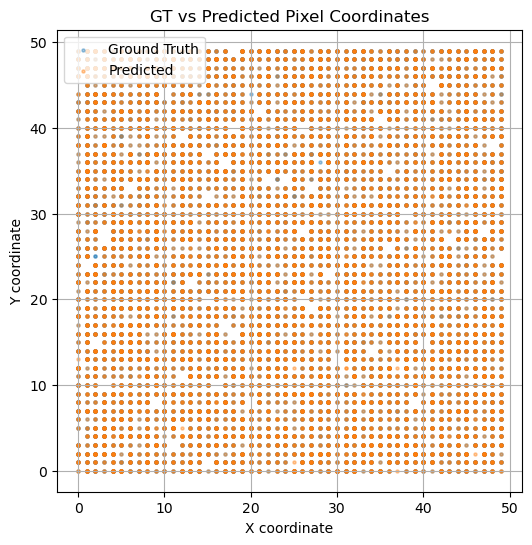

In [220]:
# -------------------------
# GT vs Predicted scatter plot (HEATMAP MODEL)
# -------------------------

# Predict heatmaps
y_pred_heatmaps = model.predict(X_val, verbose=0)

# Decode predicted heatmaps → (x, y)
def decode_heatmap(hm):
    hm = hm.squeeze()  # (50, 50)
    y, x = np.unravel_index(np.argmax(hm), hm.shape)
    return x, y

y_pred_coords = np.array([decode_heatmap(hm) for hm in y_pred_heatmaps])

# Ground-truth coordinates (kept during split)
y_true_coords = coords_val


plt.figure(figsize=(6, 6))

plt.scatter(
    y_true_coords[:, 0],
    y_true_coords[:, 1],
    s=5,
    alpha=0.4,
    label="Ground Truth"
)

plt.scatter(
    y_pred_coords[:, 0],
    y_pred_coords[:, 1],
    s=5,
    alpha=0.4,
    label="Predicted"
)

plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("GT vs Predicted Pixel Coordinates")
plt.legend()
plt.grid(True)
plt.show()


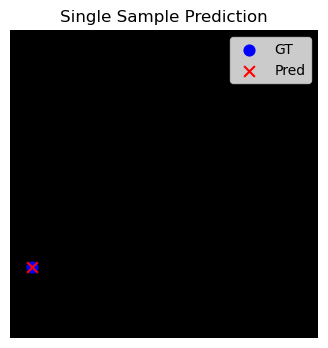

In [221]:
idx = np.random.randint(0, len(X_val))

plt.figure(figsize=(4, 4))
plt.imshow(X_val[idx].squeeze(), cmap="gray")
plt.scatter(
    y_true_coords[idx][0],
    y_true_coords[idx][1],
    c="blue",
    s=60,
    label="GT"
)
plt.scatter(
    y_pred_coords[idx][0],
    y_pred_coords[idx][1],
    c="red",
    s=60,
    marker="x",
    label="Pred"
)
plt.legend()
plt.title("Single Sample Prediction")
plt.axis("off")
plt.show()


Predicted pixel location → x=23, y=24


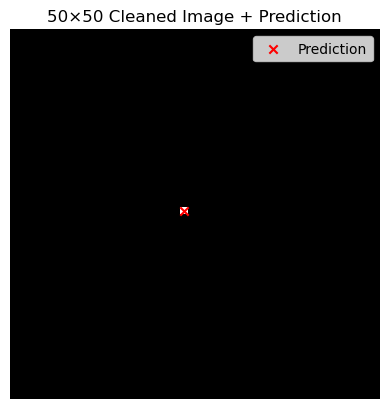

In [222]:
#Test on Real-time data
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# -------------------------
# Configuration
# -------------------------
IMAGE_SIZE = 50
MODEL_PATH = "pixel_coordinate_regressor.keras"
IMAGE_PATH = "image.png"

# -------------------------
# Load model
# -------------------------
model = tf.keras.models.load_model(MODEL_PATH)

# -------------------------
# Load & resize image
# -------------------------
image = Image.open(IMAGE_PATH).convert("L")
image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
image = np.array(image, dtype=np.uint8)

# -------------------------
# Signal-preserving cleaning
# -------------------------
cleaned = np.zeros_like(image)
y_sig, x_sig = np.unravel_index(np.argmax(image), image.shape)
cleaned[y_sig, x_sig] = 255

# -------------------------
# Normalize & reshape
# -------------------------
input_tensor = cleaned.astype("float32") / 255.0
input_tensor = input_tensor[np.newaxis, ..., np.newaxis]

# -------------------------
# Predict
# -------------------------
heatmap = model.predict(input_tensor, verbose=0)[0]
hm = heatmap.squeeze()
pred_y, pred_x = np.unravel_index(np.argmax(hm), hm.shape)

# -------------------------
# Output
# -------------------------
print(f"Predicted pixel location → x={pred_x}, y={pred_y}")

# Optional visualization
plt.imshow(cleaned, cmap="gray")
plt.scatter(pred_x, pred_y, c="red", marker="x", label="Prediction")
plt.legend()
plt.title("50×50 Cleaned Image + Prediction")
plt.axis("off")
plt.show()
